In [10]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Read in the Pandas DataFrame
malware_pdf = pd.read_csv("./Android_Permission.csv")

# Look at the head of it
malware_pdf.head()
malware_pdf.columns
malware_pdf.shape

(29999, 184)

In [12]:
malware_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Columns: 184 entries, App to Class
dtypes: float64(3), int64(176), object(5)
memory usage: 42.1+ MB


In [13]:
# Drop all the columns we don't care about
malware_pdf = malware_pdf.drop('App', axis=1)
malware_pdf = malware_pdf.drop('Package', axis=1)
malware_pdf = malware_pdf.drop('Category', axis=1)
malware_pdf = malware_pdf.drop('Description', axis=1)
malware_pdf = malware_pdf.drop('Rating', axis=1)
malware_pdf = malware_pdf.drop('Number of ratings', axis=1)
malware_pdf = malware_pdf.drop('Price', axis=1)
malware_pdf = malware_pdf.drop('Related apps', axis=1)
malware_pdf = malware_pdf.drop('Dangerous permissions count', axis=1)
malware_pdf = malware_pdf.drop('Safe permissions count', axis=1)

print(malware_pdf.shape)
malware_pdf = malware_pdf.dropna()
malware_pdf.shape


(29999, 174)


(29999, 174)

In [14]:
# Based on our sample size of only 29,999 apps, our margin of error is 0.6%
# (margin of error in percent = 100 / sqrt(N)) ==> 100 / sqrt(29999)
# And 0.6% of 29,999 apps is 180 apps.  So if less than 180 apps have a 
# feature, it's less than our margin of error and statistically insignificant,
# so we'll drop those permission columns.
PERM_THRESHOLD = 180             # Number of apps which must have a certain permission to keep it
NUM_APPS = malware_pdf.shape[0]  # 29,999

too_few_col_dropper = []    # We'll store column headers to be dropped in this list.  These are permissions that not many apps have
too_many_col_dropper = []   # Too many apps have these permissions for predictive value

# value_counts() returns a Pandas series, where the 0 key counts how many did not
# have the feature, and 1 counts how many that did.  

# Note that if none had the feature, then the 1 key will not be present,
# and we get a key error.  We could check for the 0 case is 29999, but
# I think that's a bit kludgy.  Thankfully, Pandas series supports the
# .get() method, which can return a default value if key error.

# p.s. Don't look at the last column, which is the class label


for col in malware_pdf.columns[:-1]:
    # If the value count key is not found, there are 0 counts
    if (malware_pdf[col].value_counts().get(1, 0) < PERM_THRESHOLD):
        too_few_col_dropper.append(col)
        
print(f"There are {len(too_few_col_dropper)} permissions that less than {PERM_THRESHOLD} apps have, and will therefore be dropped.")

# Similarly, are there any permissions that almost ALL apps have (unlikely), 
# that also gives them little predictive value.
for col in malware_pdf.columns[:-1]:
    # If the value count key is not found, there are 0 counts
    if (malware_pdf[col].value_counts().get(1, 0) > (NUM_APPS - PERM_THRESHOLD)):
        too_many_col_dropper.append(col)
        
# Turns out none fit this bill, but that's OK - code is reusable
print(f"There are {len(too_many_col_dropper)} permissions that more than than {NUM_APPS - PERM_THRESHOLD} apps have, and will therefore be dropped.")

# Drop the columns
malware_pdf = malware_pdf.drop(malware_pdf[too_few_col_dropper], axis=1)
malware_pdf = malware_pdf.drop(malware_pdf[too_many_col_dropper], axis=1)
malware_pdf.shape

There are 122 permissions that less than 180 apps have, and will therefore be dropped.
There are 0 permissions that more than than 29819 apps have, and will therefore be dropped.


(29999, 52)

In [15]:
from sklearn.model_selection import train_test_split

# First let's get the class labels 
y = malware_pdf['Class']

# And drop them from X (which loses the column headers)
X = malware_pdf.drop(['Class'], axis=1)

# Convert y labels to NumPy array for learning
y = np.array(y)

print(f"X: {X.shape} of type {type(X)}")
print(f"y: {y.shape} of type {type(y)}")

X: (29999, 51) of type <class 'pandas.core.frame.DataFrame'>
y: (29999,) of type <class 'numpy.ndarray'>


In [16]:
# Split the data.  Let's do a 80/10/10 split for train/val/test
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=42)        # 20% goes to temp variable
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)  # which is then split in half to make val and test sets

# Try adding a dimension here to fix training issue, not learning.  ==>  Wasn't an issue, dropping this.
# y_train = np.expand_dims(y_train, axis=1)
# y_val = np.expand_dims(y_val, axis=1)
# y_test = np.expand_dims(y_test, axis=1)

# Confirm sizes and types.  Note that all X are converted to NumPy ndarrays!
print(f"X_train: {X_train.shape} of type {type(X_train)}")
print(f"y_train: {y_train.shape} of type {type(y_train)}\n")

print(f"X_val: {X_val.shape} of type {type(X_val)}")
print(f"y_val: {y_val.shape} of type {type(y_val)}\n")

print(f"X_test: {X_test.shape} of type {type(X_test)}")
print(f"y_test: {y_test.shape} of type {type(y_test)}\n")

X_train: (23999, 51) of type <class 'pandas.core.frame.DataFrame'>
y_train: (23999,) of type <class 'numpy.ndarray'>

X_val: (3000, 51) of type <class 'pandas.core.frame.DataFrame'>
y_val: (3000,) of type <class 'numpy.ndarray'>

X_test: (3000, 51) of type <class 'pandas.core.frame.DataFrame'>
y_test: (3000,) of type <class 'numpy.ndarray'>



In [17]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))  # Not using the GPU here, not necessary with such a small dataset

2.18.0
[]


In [18]:
import tensorflow as tf

# Define focal loss function
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        loss_val = alpha * tf.pow((1 - p_t), gamma) * bce
        return tf.reduce_mean(loss_val)
    return loss

# Define model
input_size = X_train.shape[1]
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.1)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, kernel_initializer="he_normal", input_shape=(input_size,)),
    tf.keras.layers.BatchNormalization(),
    leaky_relu,
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(128, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    leaky_relu,
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    leaky_relu,
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(32, kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    leaky_relu,
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Optimizer
opt = tf.keras.optimizers.Nadam(learning_rate=0.001)

# Compile
model.compile(
    optimizer=opt, 
    loss=focal_loss(gamma=2, alpha=0.25), 
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.FalseNegatives(name="fn"),
        tf.keras.metrics.FalsePositives(name="fp"),
        tf.keras.metrics.TrueNegatives(name="tn"),
        tf.keras.metrics.TruePositives(name="tp")
    ]
)



c:\Users\prane\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\prane\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
baseline_model = model
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,497 (228.50 KB)

 Trainable params: 57,537 (224.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [20]:
BATCH_SIZE = 512  

early_stopping_patience = 9
reduce_lr_on_plateau_patience = 5

assert reduce_lr_on_plateau_patience < early_stopping_patience 
early_stopping = tf.keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=reduce_lr_on_plateau_patience)

history = baseline_model.fit(X_train, 
                    y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=1000,                     # Early Stopping will happen much sooner, set high to always be stopped by early stopping
                    callbacks=[early_stopping, reduce_lr_on_plateau], 
                    validation_data=(X_val, y_val),
                    verbose=1
                   )

Epoch 1/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5246 - auc: 0.5400 - fn: 3849.1667 - fp: 1943.1041 - loss: 0.0538 - precision: 0.6972 - recall: 0.5129 - tn: 2206.4792 - tp: 4531.8750 - val_accuracy: 0.6270 - val_auc: 0.6097 - val_fn: 513.0000 - val_fp: 606.0000 - val_loss: 0.0392 - val_precision: 0.7099 - val_recall: 0.7430 - val_tn: 398.0000 - val_tp: 1483.0000 - learning_rate: 0.0010
Epoch 2/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6266 - auc: 0.5749 - fn: 1588.9166 - fp: 3046.2500 - loss: 0.0384 - precision: 0.6898 - recall: 0.7954 - tn: 1165.7500 - tp: 6729.7085 - val_accuracy: 0.6653 - val_auc: 0.6326 - val_fn: 108.0000 - val_fp: 896.0000 - val_loss: 0.0341 - val_precision: 0.6782 - val_recall: 0.9459 - val_tn: 108.0000 - val_tp: 1888.0000 - learning_rate: 0.0010
Epoch 3/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6540 - auc: 0.5979 - fn: 950.0625 - fp: 3392.2083 - loss: 0.0349 - precision: 0.6876 - recall: 0.8843 - tn: 777.0833 

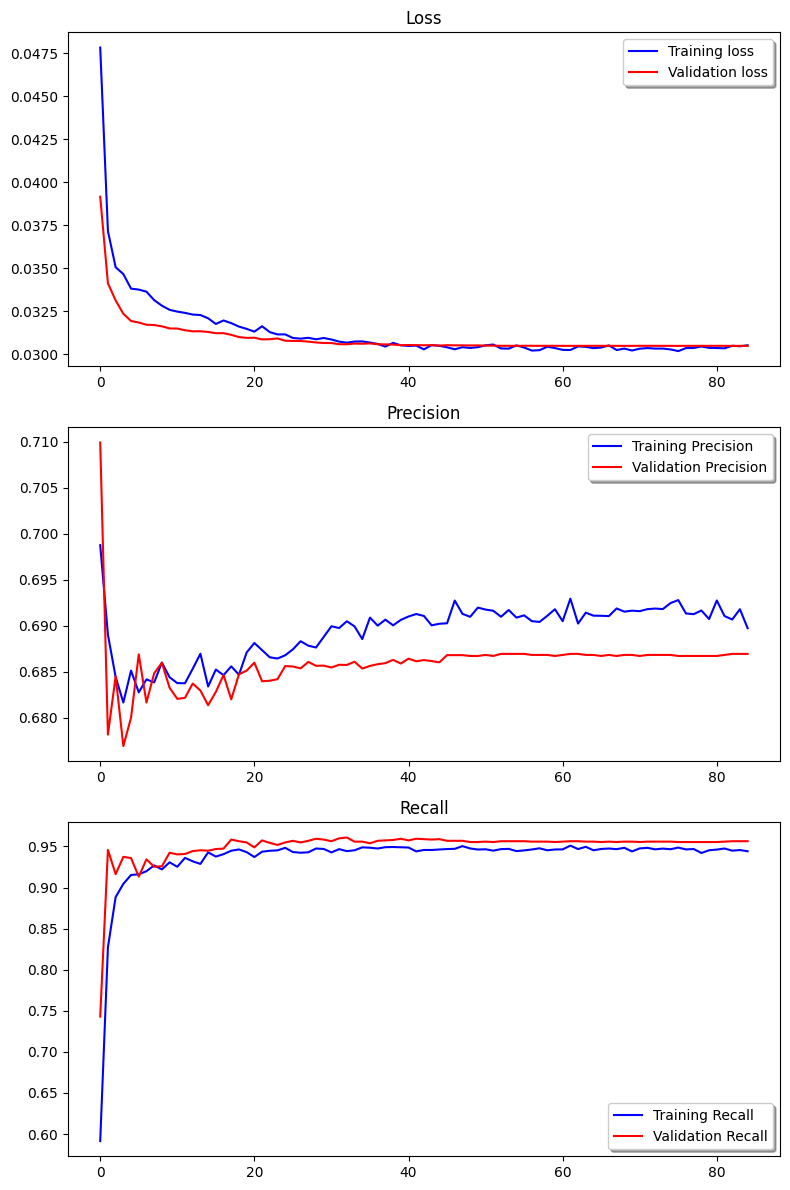

In [21]:
# Plot loss
fig, ax = plt.subplots(3,1, figsize=(8,12))

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("Loss")

# Plot Precision
ax[1].plot(history.history['precision'], color='b', label="Training Precision")
ax[1].plot(history.history['val_precision'], color='r', label="Validation Precision")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Precision")

# Plot Recall
ax[2].plot(history.history['recall'], color='b', label="Training Recall")
ax[2].plot(history.history['val_recall'], color='r', label="Validation Recall")
ax[2].legend(loc='best', shadow=True)
ax[2].set_title("Recall")

plt.tight_layout()
plt.show()


loss :  0.030233850702643394
compile_metrics :  0.6779999732971191

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Legitimate Benign Apps Detected (True Negatives):  113
Legitimate Benign Apps Incorrectly Detected (False Positives):  876
Malicious Apps Missed (False Negatives):  90
Malicious Apps Detected (True Positives):  1921
Total Malicious Apps:  2011


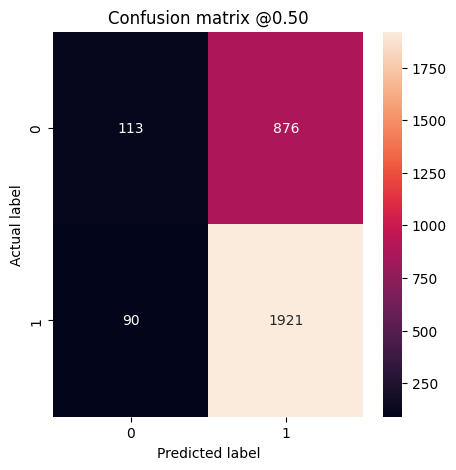

In [22]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Benign Apps Detected (True Negatives): ', cm[0][0])
  print('Legitimate Benign Apps Incorrectly Detected (False Positives): ', cm[0][1])
  print('Malicious Apps Missed (False Negatives): ', cm[1][0])
  print('Malicious Apps Detected (True Positives): ', cm[1][1])
  print('Total Malicious Apps: ', np.sum(cm[1]))

# Get the baseline results for the original model (without the class weights)
baseline_results = baseline_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(baseline_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

test_predictions_baseline = baseline_model.predict(X_test, batch_size=BATCH_SIZE)

plot_cm(y_test, test_predictions_baseline)


Best F1-Score to beat is 0.8047696038803557 with threshold 0.4.


c:\Users\prane\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


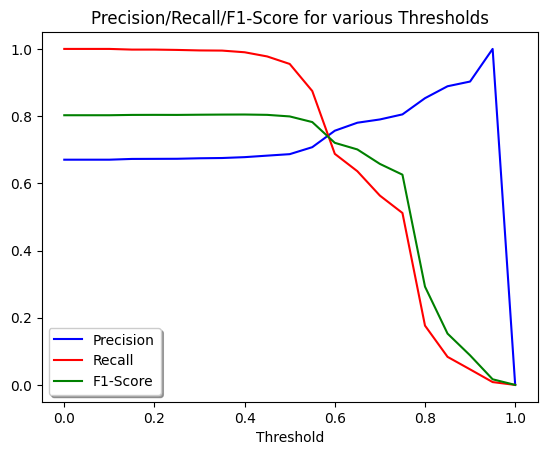

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Set threshold from 0.0 to 1.0 in 0.05 increments
thresh_list = np.arange(0, 1.05, 0.05).tolist()

P_list = []
R_list = []
F1_list = []

# Calculate P and R for each threshold
for thresh in thresh_list:
    # Get predictions from the model on the test set, these are probabilities
    pred_baseline = baseline_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
    
    # Need to convert these probabilities into predictions based on the threshold
    y_hat_pred = (pred_baseline > thresh).astype("int32")  # Snap to binary class labels based on threshold
    
    # Add the metrics to the proper lists
    P_list.append(precision_score(y_test, y_hat_pred))
    R_list.append(recall_score(y_test, y_hat_pred))
    F1_list.append(f1_score(y_test, y_hat_pred))

plt.plot(thresh_list, P_list, color='b', label="Precision")
plt.plot(thresh_list, R_list, color='r', label="Recall")
plt.plot(thresh_list, F1_list, color='g', label="F1-Score")
plt.xlabel('Threshold')
plt.title('Precision/Recall/F1-Score for various Thresholds')
plt.legend(loc='best', shadow=True)  

print(f"\nBest F1-Score to beat is {F1_list[np.argmax(F1_list)]} with threshold {thresh_list[np.argmax(F1_list)]}.")


In [29]:
from sklearn.metrics import f1_score, precision_recall_curve
import numpy as np
import joblib

# --- This assumes the model has been trained and is in a variable named 'model_v3' ---
# --- and the scaler is in a variable named 'scaler' ---

# Predict probabilities on the test set to find the best threshold
y_pred_probs = model.predict(X_test, batch_size=512)

# Find the optimal threshold that maximizes F1-score
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
# Add a small epsilon to avoid division by zero
f1_scores = 2 * recall * precision / (recall + precision + 1e-7)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold found: {optimal_threshold:.4f}")
print(f"Best F1-Score on Test Set: {f1_scores[optimal_idx]:.4f}")

# --- 1. Save the new model ---
model_v3_filename = 'model_app_v3.keras'
model.save(model_v3_filename)
print(f"New TensorFlow model saved as '{model_v3_filename}'")

# --- 2. Save features and scaler parameters for the backend ---
feature_list_v3_filename = 'model_app_features_v3.joblib'
scaled_columns = ['Rating', 'Number of ratings', 'Dangerous permissions count']
required_features_v3 = {
    "columns": list(X.columns),
    "optimal_threshold": optimal_threshold,
    "scaled_columns": scaled_columns,
    "scaler_mean": scaler.mean_,
    "scaler_scale": scaler.scale_
}
joblib.dump(required_features_v3, feature_list_v3_filename)
print(f"New feature list and scaler parameters saved as '{feature_list_v3_filename}'")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Optimal Threshold found: 0.4453
Best F1-Score on Test Set: 0.8055
New TensorFlow model saved as 'model_app_v3.keras'
New feature list and scaler parameters saved as 'model_app_features_v3.joblib'
